# Adding keyword labels to O&M data
This notebook demonstrates the use of the `pvops.classify.get_attributes_from_keywords` module for adding asset labels based off O&M notes.

In [26]:
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.metrics import accuracy_score

from pvops.text import utils, preprocess
from pvops.text.classify import get_attributes_from_keywords
from pvops.text.visualize import visualize_classification_confusion_matrix
from example_data.reference_dict import EQUIPMENT_DICT, PV_TERMS_DICT

# Step 0: Get sample data, remap assets

In [27]:
# pull in sample data and remap assets for ease of comparison

om_df = pd.read_csv('example_data/example_ML_ticket_data.csv')
col_dict = {
    "data" : "CompletionDesc",
    "eventstart" : "Date_EventStart",
    "save_data_column" : "processed_data",
    "save_date_column" : "processed_date",
    "attribute_col" : "Asset",
    "predicted_col" : "Keyword_Asset",
    "remapping_col_from": "in",
    "remapping_col_to": "out_"
}

# remap assets
remapping_df = pd.read_csv('example_data/remappings_asset.csv')
remapping_df['out_'] = remapping_df['out_'].replace({'met station': 'met',
                                                        'energy storage': 'battery',
                                                        'energy meter': 'meter'})
om_df = utils.remap_attributes(om_df, remapping_df, col_dict, allow_missing_mappings=True)
om_df.head()

,Date_EventStart,Date_EventEnd,Asset,CompletionDesc,Cause,ImpactLevel,randid
0,8/16/2018 9:00,8/22/2018 17:00,combiner,cb 1.18 was found to have contactor issue woul...,0000 - Unknown.,Underperformance,38
1,9/17/2018 18:25,9/18/2018 9:50,transformer,self resolved. techdispatched: no,004 - Under voltage.,Underperformance,46
2,8/26/2019 9:00,11/5/2019 17:00,facility,"all module rows washed, waiting for final repo...",0000 - Unknown,Underperformance,62
3,11/14/2017 7:46,11/14/2017 8:35,inverter,14 nov: we were alerted that e-c3-1 had faulte...,019 - Unplanned outage/derate.,Underperformance,54
4,4/27/2019 9:00,5/2/2019 17:00,facility,assessed condition filters all inverters. litt...,.,NaN,45


# Step 1: Text preprocessing

In [28]:
# preprocessing steps
om_df[col_dict['attribute_col']] = om_df.apply(lambda row: row[col_dict['attribute_col']].lower(), axis=1)
equipment_dict = {k:EQUIPMENT_DICT[k] for k in EQUIPMENT_DICT if len(EQUIPMENT_DICT[k]) > 1}
pv_reference_dict = {**equipment_dict, **PV_TERMS_DICT}
om_df = preprocess.preprocessor(om_df, lst_stopwords=[], col_dict=col_dict, pv_reference_dict=pv_reference_dict, print_info=False, extract_dates_only=False)

# tokenize notes to words
DATA_COL = col_dict['data']
om_df[DATA_COL] = om_df[DATA_COL].apply(word_tokenize)

om_df.head()

,Date_EventStart,Date_EventEnd,Asset,CompletionDesc,Cause,ImpactLevel,randid,processed_date,processed_data
0,8/16/2018 9:00,8/22/2018 17:00,combiner,"[cb, 1.18, was, found, to, have, contactor, is...",0000 - Unknown.,Underperformance,38,[],cb was found to have contactor issue would not...
1,9/17/2018 18:25,9/18/2018 9:50,transformer,"[self, resolved, ., techdispatched, :, no]",004 - Under voltage.,Underperformance,46,[],self resolved techdispatched no
2,8/26/2019 9:00,11/5/2019 17:00,facility,"[all, module, rows, washed, ,, waiting, for, f...",0000 - Unknown,Underperformance,62,[2019-09-01 09:00:00],all module rows washed waiting for final repor...
3,11/14/2017 7:46,11/14/2017 8:35,inverter,"[14, nov, :, we, were, alerted, that, e-c3-1, ...",019 - Unplanned outage/derate.,Underperformance,54,"[2017-11-14 07:46:00, 2017-03-01 07:46:00]",nov we were alerted that e c had faulted by up...
4,4/27/2019 9:00,5/2/2019 17:00,facility,"[assessed, condition, filters, all, inverters,...",.,NaN,45,[],assessed condition filters all inverters littl...


# Step 2: Search for keywords to use as labels

In [29]:
# add asset labels from keyword reference dict
om_df = get_attributes_from_keywords(om_df=om_df,
                                     col_dict=col_dict,
                                     reference_dict=EQUIPMENT_DICT)
om_df.head()

5 entries had multiple keywords of interest. Reference: Int64Index([16, 36, 48, 57, 78], dtype='int64') in original dataframe.


,Date_EventStart,Date_EventEnd,Asset,CompletionDesc,Cause,ImpactLevel,randid,processed_date,processed_data,Keyword_Asset
0,8/16/2018 9:00,8/22/2018 17:00,combiner,"[cb, 1.18, was, found, to, have, contactor, is...",0000 - Unknown.,Underperformance,38,[],cb was found to have contactor issue would not...,combiner
1,9/17/2018 18:25,9/18/2018 9:50,transformer,"[self, resolved, ., techdispatched, :, no]",004 - Under voltage.,Underperformance,46,[],self resolved techdispatched no,NaN
2,8/26/2019 9:00,11/5/2019 17:00,facility,"[all, module, rows, washed, ,, waiting, for, f...",0000 - Unknown,Underperformance,62,[2019-09-01 09:00:00],all module rows washed waiting for final repor...,module
3,11/14/2017 7:46,11/14/2017 8:35,inverter,"[14, nov, :, we, were, alerted, that, e-c3-1, ...",019 - Unplanned outage/derate.,Underperformance,54,"[2017-11-14 07:46:00, 2017-03-01 07:46:00]",nov we were alerted that e c had faulted by up...,inverter
4,4/27/2019 9:00,5/2/2019 17:00,facility,"[assessed, condition, filters, all, inverters,...",.,NaN,45,[],assessed condition filters all inverters littl...,NaN


# Step 3: Metrics

In [30]:
# get accuracy measures and count metrics
PREDICT_COL = col_dict['predicted_col']
LABEL_COL = col_dict['attribute_col']

# entries with some keyword over interest, over all entries
label_count = om_df[PREDICT_COL].count() / len(om_df)

# replace 'Other' values with 'Unknown'
om_df[LABEL_COL] = om_df[LABEL_COL].replace('other', 'unknown')
# replace NaN values to use accuracy score
om_df[[LABEL_COL, PREDICT_COL]] = om_df[[LABEL_COL, PREDICT_COL]].fillna('unknown')
acc_score = accuracy_score(y_true=om_df[LABEL_COL], y_pred=om_df[PREDICT_COL])

msg = f'{label_count:.2%} of entries had a keyword of interest, with {acc_score:.2%} accuracy.'
print(msg)

45.79% of entries had a keyword of interest, with 28.04% accuracy.


# Step 4: Visualization

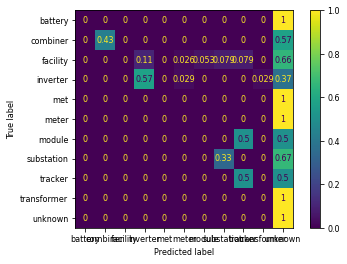

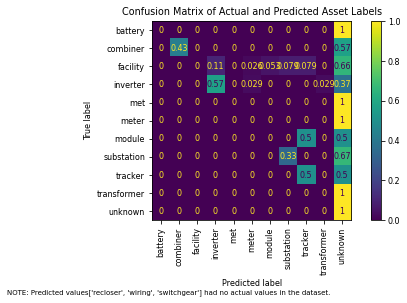

In [32]:
# plot confusion matrix
title = 'Confusion Matrix of Actual and Predicted Asset Labels'
visualize_classification_confusion_matrix(om_df, col_dict, title)